In [3]:
from timm.models.efficientnet import tf_efficientnet_b3_ns, tf_efficientnet_b5_ns

In [24]:
from timm.models import efficientnet as tf_efficientnet

In [5]:
model = tf_efficientnet_b3_ns(pretrained=True)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b3_ns-9d44bf68.pth" to /root/.cache/torch/checkpoints/tf_efficientnet_b3_ns-9d44bf68.pth


In [26]:
model.classifier.in_features

1536

In [6]:
model

EfficientNet(
  (conv_stem): Conv2dSame(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(40, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SwishMe()
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
        (bn1): BatchNorm2d(40, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SwishMe()
        (se): SqueezeExcite(
          (avg_pool): AdaptiveAvgPool2d(output_size=1)
          (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
          (act1): SwishMe()
          (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
     

In [20]:
modules = list(model.children())[:-2]
enc = nn.Sequential(*modules)

In [21]:
x = torch.ones((3,224,224)).float()

In [23]:
enc(x[None,...]).shape

torch.Size([1, 1536, 7, 7])

In [19]:
import torch
import torch.nn as nn

In [18]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from sklearn.metrics import roc_auc_score, log_loss, roc_curve, auc

import sys
sys.path.append('../')

TEXT_COLOR = 'w'
FACECOLOR = '#373d4b'
mpl.rcParams['axes.facecolor'] = '#373d4b'
mpl.rcParams['text.color'] = TEXT_COLOR
mpl.rcParams['axes.labelcolor'] = TEXT_COLOR
mpl.rcParams['xtick.color'] = TEXT_COLOR
mpl.rcParams['ytick.color'] = TEXT_COLOR

import albumentations
from melanoma.core.losses import BCELabelSmoothingLoss
from melanoma.data.dataset import MelanomaDataset
from melanoma.data.augmentation import MelanomaAugmentor
from melanoma.utils import data_utils
from melanoma.utils.data_utils import load_data

In [3]:
image_map={
    '2020':'../data/ISIC_2020/224x224_jpg_100_4/train/',
    '2019': '../data/ISIC_2019/224x224_jpg_100_4/train/'
}
df_train = load_data('../data/train.csv', 
                     duplicate_path='../data/sus/2020_Challenge_duplicates.csv', 
                     external_filepaths=['../data/external_data/isic_2019.csv'],
                     image_map=image_map
                    )
root = '../data/ISIC_2020/224x224_jpg_100_4'
df_train['image_dir'] = root
ds = MelanomaDataset(df_train, 'train')

img_stats = data_utils.load_img_stats('../data/cv_folds/cv_folds_20200802_0048/224x224_jpg_100_4/', 0)
mean = np.array(img_stats['source']['ISIC_2020']['mean'], np.float32)
std = np.array(img_stats['source']['ISIC_2020']['std'], np.float32)

Adding external data from ../data/external_data/isic_2019.csv
Loading img stats for fold 0 from ../data/cv_folds/cv_folds_20200802_0048/224x224_jpg_100_4/fold_0/img_stats.json


In [8]:
ds = MelanomaDataset(df_train, 'train')

In [13]:
idx = 50
x,y = ds[idx]
img = data_utils.load_image(os.path.join(root, 'train'), ds.df['image_name'].iloc[idx])

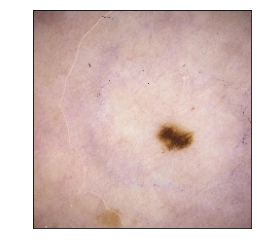

In [14]:
plt.imshow(img)

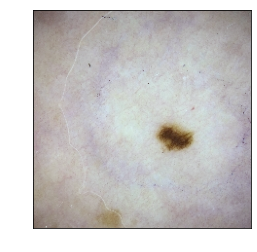

In [19]:
plt.imshow(color_constancy(img))

In [53]:
plt.imshow(color_constancy(img, gamma=2))

In [60]:
class ColorConstancy(DualTransform):
    
    def __init__(self, 
                 power=6,
                 gamma=None,
                 always_apply=False,
                 p=0.5):
        self._power = power
        self._gamma = gamma
        super(ColorConstancy, self).__init__(p, always_apply)
    
    def apply(self, img, **params):
        img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
        img_dtype = img.dtype

        if self._gamma is not None:
            img = img.astype('uint8')
            look_up_table = np.ones((256 ,1), dtype='uint8') * 0
            for i in range(256):
                look_up_table[i][0] = 255*pow(i/255, 1/self._gamma)
            img = cv2.LUT(img, look_up_table)

        img = img.astype('float32')
        img_power = np.power(img, self._power)
        rgb_vec = np.power(np.mean(img_power, (0,1)), 1/self._power)
        rgb_norm = np.sqrt(np.sum(np.power(rgb_vec, 2.0)))
        rgb_vec = rgb_vec/rgb_norm
        rgb_vec = 1/(rgb_vec*np.sqrt(3))
        img = np.multiply(img, rgb_vec)

        img = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2RGB)
        return img.astype(img_dtype)
    
    def get_transform_init_args_names(self):
        return ("power", "gamma")

In [61]:
aug = ColorConstancy()

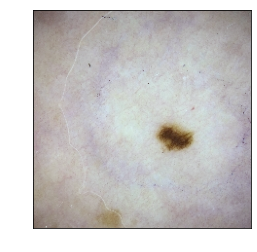

In [62]:
plt.imshow(aug(image=img)['image'])

In [54]:
import cv2 

def color_constancy(img, power=6, gamma=None):
    img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img_dtype = img.dtype

    if gamma is not None:
        img = img.astype('uint8')
        look_up_table = np.ones((256 ,1), dtype='uint8') * 0
        for i in range(256):
            look_up_table[i][0] = 255*pow(i/255, 1/gamma)
        img = cv2.LUT(img, look_up_table)

    img = img.astype('float32')
    img_power = np.power(img, power)
    rgb_vec = np.power(np.mean(img_power, (0,1)), 1/power)
    rgb_norm = np.sqrt(np.sum(np.power(rgb_vec, 2.0)))
    rgb_vec = rgb_vec/rgb_norm
    rgb_vec = 1/(rgb_vec*np.sqrt(3))
    img = np.multiply(img, rgb_vec)

    img = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2RGB)
    return img.astype(img_dtype)

In [4]:
from albumentations import ImageOnlyTransform

In [5]:
# class HairAugmentation(ImageOnlyTransform):
    
#     def __init__(self, root, num_hairs=4):
#         self.root = root
#         self.num_hairs = num_hairs
    
#     def apply(self, img, **params):
        

In [55]:
import random
from albumentations import DualTransform

class CoarseDropout(DualTransform):
    
    def __init__(self, 
                 n=4,
                 scale=.1,
                 n_max=None,
                 scale_max=None,
                 fill_value=0,
                 fill_params=None,
                 always_apply=False,
                 p=.5):
        super(CoarseDropout, self).__init__(p, always_apply)
        self._n = n
        self._scale = scale
        self._fill_value = fill_value
        self._n_max = n if n_max is None else n_max
        self._scale_max = scale if scale_max is None else scale_max
        self._fill_params = fill_params
        if self._fill_params is not None:
            self._fill_method = self._fill_params['method']
            self._fill_stats = self._fill_params.get('params', {})
    
    def apply(self, img, **params):
        img = img.copy()
        h, w, d = img.shape
        n = random.randint(self._n, self._n_max)
        
        for i in range(n):
            h_0 = random.randint(0, h)
            w_0 = random.randint(0, w)
            scale = random.uniform(self._scale, self._scale_max)
            dim = int(scale * h) // 2

            hb = [max(0, h_0 - dim), min(h, h_0 + dim)]
            wb = [max(0, w_0 - dim), min(w, w_0 + dim)]
            if self._fill_params is None:
                img[slice(*hb), slice(*wb),:] = self._fill_value
            elif self._fill_method == 'normal':
                size = ((hb[1]-hb[0]), (wb[1]-wb[0]), 3)
                img[slice(*hb), slice(*wb),:] = np.random.normal(size=size, **self._fill_stats)
            else:
                size = ((hb[1]-hb[0]), (wb[1]-wb[0]), 3)
                img[slice(*hb), slice(*wb),:] = np.random.uniform(size=size, **self._fill_stats)
        
        return img
    
    def get_transform_init_args_names(self):
        return ("n", "scale", "n_max", "scale_max", "fill_value", "fill_params")

In [5]:
mus = []
sigmas = []
x_input, y = ds[8]
x = x_input.permute(1,2,0).numpy().astype(np.float32)
img = (x * 255).astype(np.uint8)
x_norm = (x-mean)/std
mus.append(x_norm.reshape(-1, 3).mean(0))
sigmas.append(x_norm.reshape(-1, 3).std(0))

In [6]:
from melanoma.utils import train_utils
from melanoma.utils import generic_utils as utils

In [74]:
config = utils.load_config_from_yaml('../input/aug_exp_1/train_config_4.yaml')

Loaded configurable file from ../input/aug_exp_1/train_config_4.yaml
{'augmentations': {'train_only': ['dropout',
                                  'compress',
                                  'shift',
                                  'gauss_noise'],
                   'transforms': {'compress': {'p': 1,
                                               'quality_lower': 70,
                                               'quality_upper': 100},
                                  'dropout': {'fill_value': 0,
                                              'n': 6,
                                              'n_max': 10,
                                              'p': 0.5,
                                              'scale': 0.05,
                                              'scale_max': 0.15},
                                  'gauss_noise': {'p': 0.1},
                                  'horizontal': {'p': 0.5},
                                  'normalize': {'mean': None, 'std': None}

In [75]:
config['augmentations']['transforms']

{'normalize': {'mean': None, 'std': None},
 'transpose': {'p': 0.5},
 'vertical': {'p': 0.5},
 'horizontal': {'p': 0.5},
 'dropout': {'p': 0.5,
  'n': 6,
  'n_max': 10,
  'scale': 0.05,
  'scale_max': 0.15,
  'fill_value': 0},
 'compress': {'p': 1, 'quality_lower': 70, 'quality_upper': 100},
 'gauss_noise': {'p': 0.1},
 'shift': {'shift_limit': 0.1,
  'scale_limit': 0.2,
  'rotate_limit': 10,
  'border_mode': 0}}

In [76]:
config['augmentations']['transforms']['normalize'] = img_stats

In [77]:
train_aug, val_aug, test_aug = train_utils.get_augmentors(**config['augmentations'],
                                                                      norm_cols=['source'])

Removing `dropout` from eval augmentations.
Removing `compress` from eval augmentations.
Removing `shift` from eval augmentations.
Removing `gauss_noise` from eval augmentations.


In [78]:
train_ds = MelanomaDataset('../data/ISIC_2020/224x224_jpg_100_4/train/', df_train, augmentor=train_aug)
val_ds = MelanomaDataset('../data/ISIC_2020/224x224_jpg_100_4/train/', df_train, augmentor=val_aug)

In [45]:
idx = 3
x,y = train_ds[idx]
img = x.permute(1,2,0).numpy()

In [50]:
print(img.reshape(-1,3).mean(0))
print(img.reshape(-1,3).std(0))

[-2.4336998 -2.724728  -2.4024508]
[1.351249   0.91933244 0.79085106]


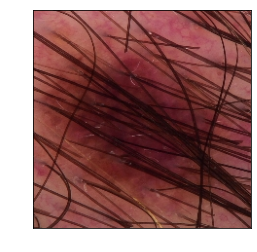

In [54]:
img = data_utils.load_image(root, ds.df['image_name'].iloc[idx])
plt.imshow(img)
x = (img/255-mean)/std

In [64]:
tmp = (img/255-mean)/std

In [84]:
a = (tmp-tmp.min())/ (tmp.max()-tmp.min())* 255

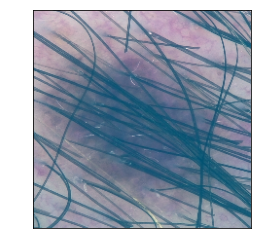

In [86]:
plt.imshow(a.astype(np.uint8))

In [80]:
(tmp-tmp.min())/(tmp.min()-tmp.max())

array([[[-0.74056604, -0.65398781, -0.71618416],
        [-0.74528302, -0.65768591, -0.71931688],
        [-0.75943396, -0.67617644, -0.73498051],
        ...,
        [-0.38207547, -0.46538448, -0.55328247],
        [-0.67924528, -0.66138402, -0.71618416],
        [-0.75      , -0.70206317, -0.75064413]],

       [[-0.73584906, -0.6465916 , -0.71931688],
        [-0.76886792, -0.67247833, -0.74124596],
        [-0.75      , -0.65768591, -0.72871506],
        ...,
        [-0.44811321, -0.51715794, -0.59714062],
        [-0.44339623, -0.483875  , -0.57207882],
        [-0.70283019, -0.67987454, -0.73184778]],

       [[-0.75471698, -0.65768591, -0.73498051],
        [-0.76415094, -0.66508212, -0.74124596],
        [-0.75      , -0.65398781, -0.73184778],
        ...,
        [-0.41981132, -0.49496932, -0.57834427],
        [-0.4245283 , -0.49127121, -0.57521155],
        [-0.40566038, -0.46908259, -0.5564152 ]],

       ...,

       [[-0.33490566, -0.48757311, -0.55014975],
        [-0

In [61]:
plt.imshow((img/255-mean)/std * 255)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [55]:
plt.imshow(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


idx 0
train 0


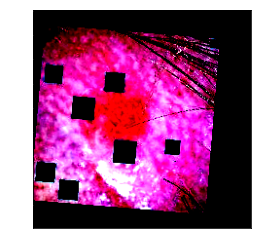

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


val 0


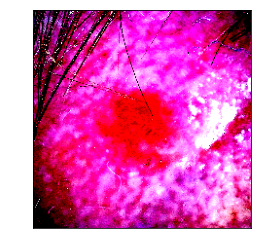

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


idx 1
train 0


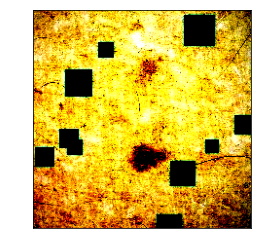

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


val 1


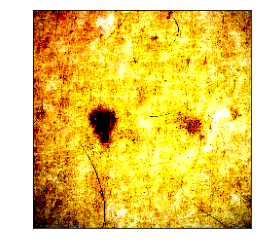

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


idx 2
train 0


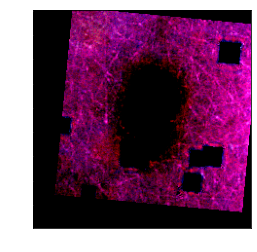

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


val 2


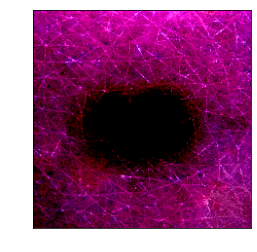

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


idx 3
train 0


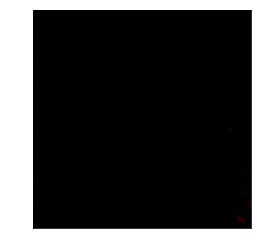

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


val 3


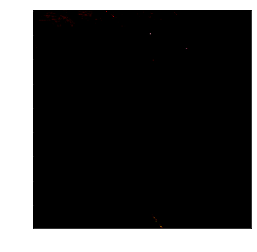

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


idx 4
train 0


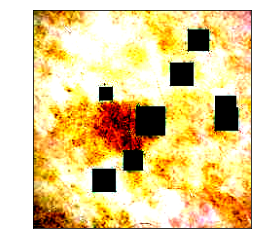

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


val 4


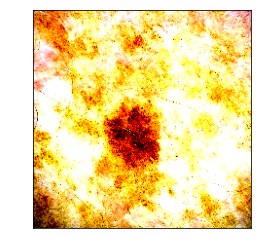

idx 5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


train 0


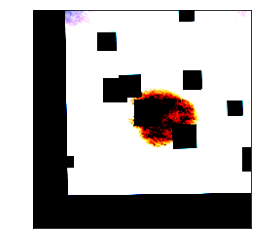

val 5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


idx 6
train 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


val 6


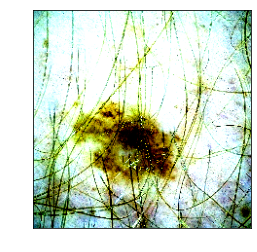

idx 7
train 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


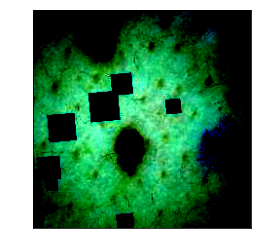

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


val 7


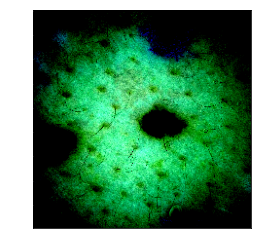

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


idx 8
train 0


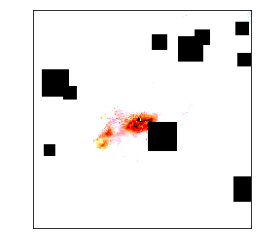

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


val 8


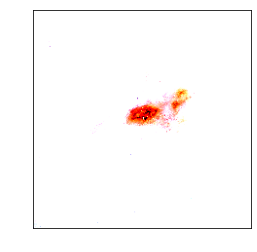

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


idx 9
train 0


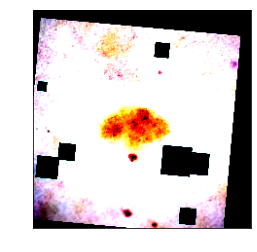

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


val 9


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


idx 10
train 0


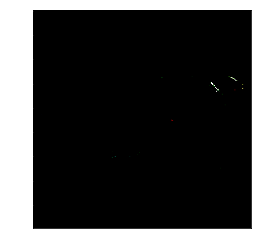

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


val 10


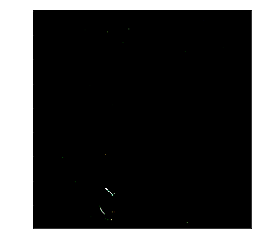

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


idx 11
train 0


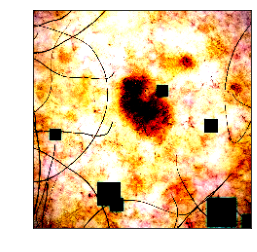

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


val 11


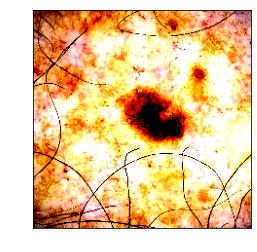

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


idx 12
train 0


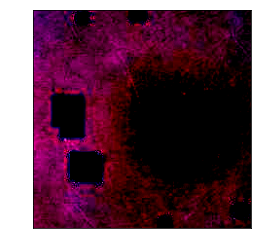

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


val 12


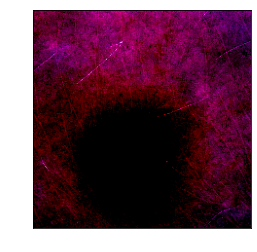

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


idx 13
train 0


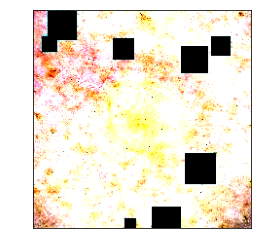

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


val 13


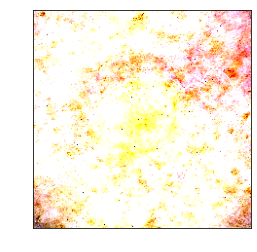

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


idx 14
train 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


val 14


idx 15
train 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


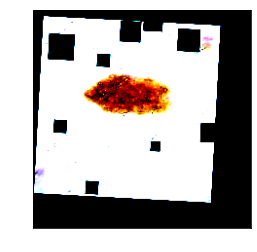

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


val 15


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


idx 16
train 0


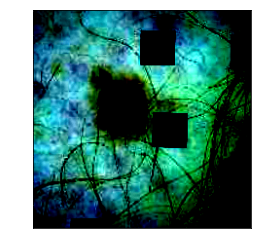

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


val 16


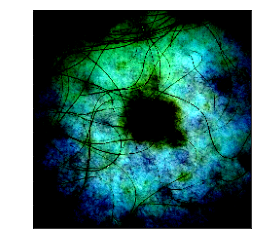

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


idx 17
train 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


val 17


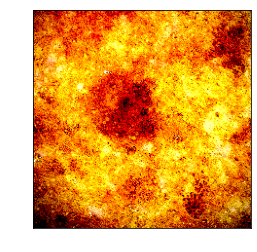

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


idx 18
train 0


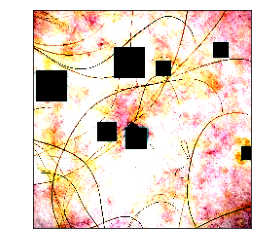

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


val 18


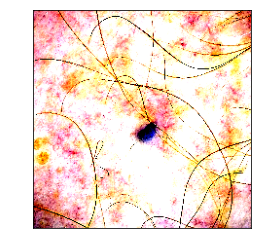

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


idx 19
train 0


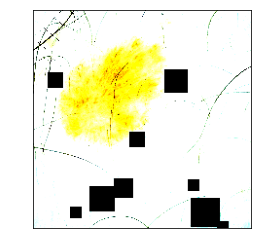

val 19


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


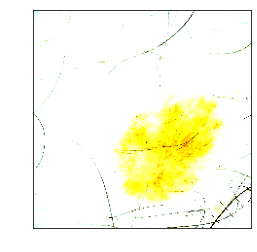

In [79]:
for i in range(20):
    print('idx', i)
    x,y = train_ds[i]
    img = x.permute(1,2,0).numpy()
    print(f'train {y}')
    plt.imshow(img); plt.show();
    
    x,y = val_ds[i]
    img = x.permute(1,2,0).numpy()
    print(f'val {i}')
    plt.imshow(img); plt.show();
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


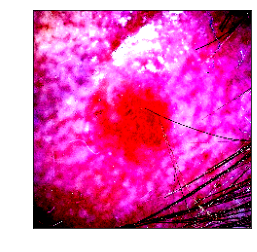

In [36]:
plt.imshow(img)

In [31]:
from torch.utils.data import DataLoader

In [ ]:
dl = DataLoader(ds, batch_size=1)

In [17]:
train_utils.get_augmentors(*config['augmentations'])

AttributeError: 'str' object has no attribute 'copy'

In [ ]:
df_hist = 

In [ ]:
df_

In [ ]:
data_utils.load_c

In [124]:
from tqdm import tqdm

In [128]:
mus = []
sigmas = []
for i in tqdm(range(5000)):
    x_input, y = ds[i]
    x = x_input.permute(1,2,0).numpy().astype(np.float32)
    x_norm = (x-mean)/std
    mus.append(x_norm.reshape(-1, 3).mean(0))
    sigmas.append(x_norm.reshape(-1, 3).std(0))

100%|██████████| 5000/5000 [00:20<00:00, 245.68it/s]


In [129]:
np.mean(mus, 0)

array([0.04808027, 0.03971811, 0.05193555], dtype=float32)

In [126]:
np.mean(mus, 0)

array([0.08427212, 0.0540082 , 0.07131755], dtype=float32)

In [130]:
np.mean(sigmas, 0)

array([0.85084367, 0.8817498 , 0.9095355 ], dtype=float32)

In [ ]:
for i in range(100):
    

In [113]:
ds.df['source'].iloc[:200].value_counts()

ISIC_2020    200
Name: source, dtype: int64

In [101]:
x_norm.reshape(-1, 3).mean(0)

array([ 0.6094715 , -0.5827362 ,  0.46030778], dtype=float32)

img


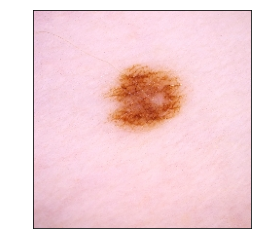

div 255


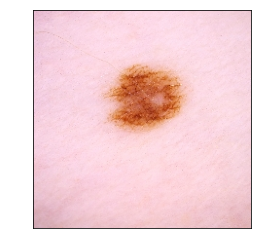

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


norm


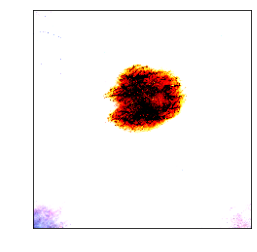

In [75]:
print('img')
plt.imshow(img); plt.show();
print('div 255')
plt.imshow(x); plt.show();
print('norm')
plt.imshow(x_norm); plt.show();

In [72]:
# aug = CoarseDropout(4, n_max=8, scale=.05, scale_max=.1, fill_value=0, p=1)
aug = albumentations.ImageCompression(quality_lower=60, quality_upper=100, p=1)
aug = albumentations.GaussNoise(p=1, )
# aug = albumentations.ToGray(p=1)
# aug = albumentations.HueSaturationValue(p=1)
# aug = albumentations.GaussianBlur(p=1, blur_limit=1)

In [59]:
aug = albumentations.GaussianBlur(p=1, blur_limit=1)
img_1 = aug(image=img)['image']
aug = albumentations.GaussianBlur(p=1, blur_limit=3)
img_3 = aug(image=img)['image']
aug = albumentations.GaussianBlur(p=1, blur_limit=7)
img_7 = aug(image=img)['image']

In [79]:
img_final.reshape(-1, 3).mean(0)

array([1.61230363, 1.54451021, 1.71777688])

In [80]:
x_norm.reshape(-1, 3).mean(0)

array([1.6563222, 1.558142 , 1.7310619], dtype=float32)

img


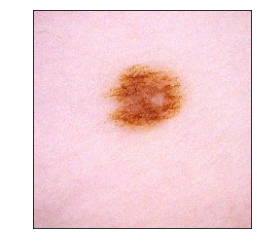

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


img then norm


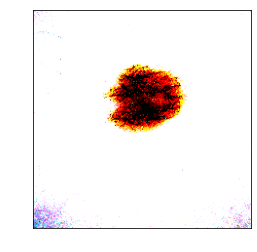

x


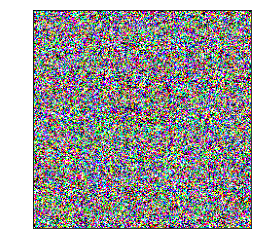

norm


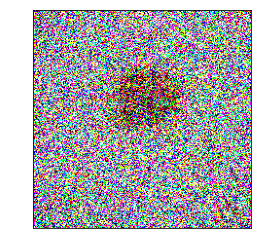

In [77]:
x_aug = aug(image=x)['image']
img_aug = aug(image=img)['image']
x_norm_aug = aug(image=x_norm)['image']
print('img')
plt.imshow(img_aug); plt.show();
print('img then norm')
img_final = (img_aug/255-mean)/std
plt.imshow(img_final); plt.show();
print('x')
plt.imshow(x_aug); plt.show();
print('norm')
plt.imshow(x_norm_aug); plt.show();

# plt.imshow(img); plt.show();
# x_255 = (x / 255).astype(np.float32)
# plt.imshow(aug(image=x_255.astype(np.float32))['image'])
# plt.imshow(aug(image=((x_255-mean)/std).astype(np.float32))['image'])
# plt.imshow(aug(image=img.astype(np.float32))['image'])

In [ ]:
class HairAugmentation(ImageOnlyTransform):
    
    def __init__(self, root, num_hairs=4):
        self.root = root
        self.num_hairs = num_hairs
    
    def apply(self, img, **params):
        

In [176]:
os.listdir('../data/melanoma_hairs/1.png')

['1.png', '4.png', '3.png', '5.png', '2.png']

In [182]:
aug = AdvancedHairAugmentation(hairs_folder='../data/melanoma_hairs/')

In [ ]:
img= 

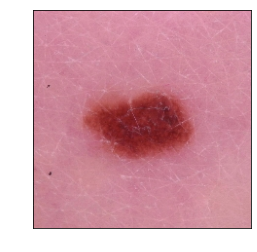

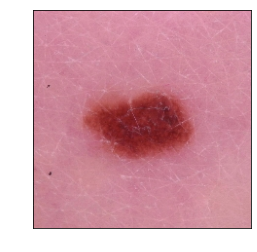

In [193]:
x, y = ds[2]
x = (x.permute(1,2,0).numpy() * 255).astype(int)
img = (x/255-mean)/std

plt.imshow(x); plt.show();
plt.imshow(aug(x));

In [89]:
aug = AdvancedHairAugmentation(2, hairs_folder='../data/melanoma_hairs/')
plt.imshow(aug(x));

['1.png', '4.png', '3.png', '5.png', '2.png']


NameError: name 'cv2' is not defined

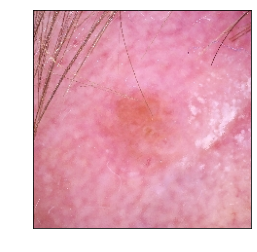

In [95]:
img = data_utils.load_image(root, ds.df['image_name'].iloc[0])
plt.imshow(img)

In [97]:
import cv2

In [101]:
hair = cv2.imread('../data/melanoma_hairs/2.png')

['1.png', '4.png', '3.png', '5.png', '2.png']


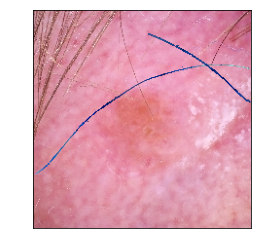

In [103]:
plt.imshow(aug(img));

In [ ]:
import random
from albumentations import DualTransform

class CoarseDropout(DualTransform):
    
    def __init__(self, 
                 n=4,
                 scale=.1,
                 n_max=None,
                 scale_max=None,
                 fill_value=0,
                 fill_params=None,
                 always_apply=False,
                 p=.5):
        super(CoarseDropout, self).__init__(p, always_apply)
        self._n = n
        self._scale = scale
        self._fill_value = fill_value
        self._n_max = n if n_max is None else n_max
        self._scale_max = scale if scale_max is None else scale_max
        self._fill_params = fill_params
        if self._fill_params is not None:
            self._fill_method = self._fill_params['method']
            self._fill_stats = self._fill_params.get('params', {})
    
    def apply(self, img, **params):
        img = img.copy()
        h, w, d = img.shape
        n = random.randint(self._n, self._n_max)
        
        for i in range(n):
            h_0 = random.randint(0, h)
            w_0 = random.randint(0, w)
            scale = random.uniform(self._scale, self._scale_max)
            dim = int(scale * h) // 2

            hb = [max(0, h_0 - dim), min(h, h_0 + dim)]
            wb = [max(0, w_0 - dim), min(w, w_0 + dim)]
            if self._fill_params is None:
                img[slice(*hb), slice(*wb),:] = self._fill_value
            elif self._fill_method == 'normal':
                size = ((hb[1]-hb[0]), (wb[1]-wb[0]), 3)
                img[slice(*hb), slice(*wb),:] = np.random.normal(size=size, **self._fill_stats)
            else:
                size = ((hb[1]-hb[0]), (wb[1]-wb[0]), 3)
                img[slice(*hb), slice(*wb),:] = np.random.uniform(size=size, **self._fill_stats)
        
        return img
    
    def get_transform_init_args_names(self):
        return ("n", "scale", "n_max", "scale_max", "fill_value", "fill_params")

In [ ]:
class AdvancedHairAugmentation(DualTransform):
    
    def __init__(self, root, num_hairs=4, max_hairs=None, p=0.5, always_apply=False):
        super(AdvancedHairAugmentation, self).__init__(always_apply, p)
        self.root = root
        self.num_hairs = num_hairs
        self.max_hairs = self.num_hairs if max_hairs is None else max_hairs

    def apply(self, img, **params):
        img = img.copy()
        num_hairs = random.randint(self.num_hairs, self.max_hairs)

        height, width, _ = img.shape  # target image width and height
        for _ in range(num_hairs):
            hair = cv2.imread(os.path.join(self.root, random.choice(self.filenames)))
            hair = cv2.flip(hair, random.choice([-1, 0, 1]))
            hair = cv2.rotate(hair, random.choice([0, 1, 2]))

            h_height, h_width, _ = hair.shape  # hair image width and height
            roi_ho = random.randint(0, img.shape[0] - hair.shape[0])
            roi_wo = random.randint(0, img.shape[1] - hair.shape[1])
            roi = img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width]

            img2gray = cv2.cvtColor(hair, cv2.COLOR_BGR2GRAY)
            ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
            mask_inv = cv2.bitwise_not(mask)
            img_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)
            hair_fg = cv2.bitwise_and(hair, hair, mask=mask)

            dst = cv2.add(img_bg, hair_fg)
            img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width] = dst

        return img
    
    def get_transform_init_args_names(self):
        return ("root" ,"num_hairs", "max_hairs"

In [142]:
for fn in aug.filenames:
    hair = cv2.imread(os.path.join(aug.root, fn))
    print(hair.shape)

(199, 113, 3)
(215, 120, 3)
(90, 236, 3)
(113, 221, 3)
(71, 106, 3)


In [143]:
hair = cv2.imread('../data/melanoma_hairs/3.png')

In [145]:
hair.shape

(90, 236, 3)

In [151]:
new_hair = cv2.resize(hair, (90, 224))

In [155]:
cv2.imwrite('../data/melanoma_hairs_224/3.png', new_hair)

True

In [156]:
tmp = cv2.imread('../data/melanoma_hairs_224/3.png')

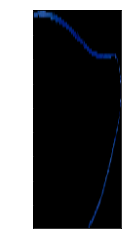

In [157]:
plt.imshow(tmp)

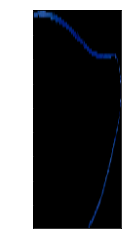

In [154]:
plt.imshow(new_hair)

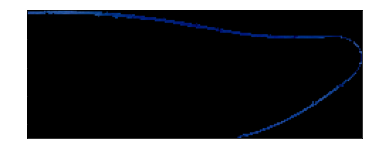

In [144]:
plt.imshow(hair)

In [170]:
aug = AdvancedHairAugmentation('../data/melanoma_hairs_224/', 10, 20)

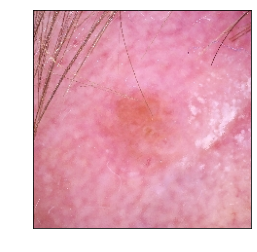

In [171]:
img = data_utils.load_image('../data/ISIC_2020/224x224_jpg_100_4/train', ds.df['image_name'].iloc[0])
plt.imshow(img)

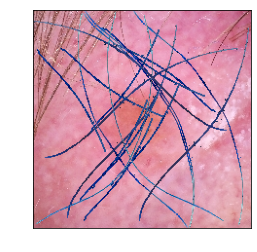

In [174]:
plt.imshow(aug(image=img)['image'])